### Imports

In [81]:
import numpy as np
import pandas as pd
import torch
import math
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
import warnings

### File paths

In [2]:
# Basic path to material directories - ALL_PATH/MAT_NAME/FILE_NAME/CUT/FRAME_NUM.jpg
ALL_PATH = '/mnt/RO-labe/VFMA/materials/EXP2/'
CUT = '/cut00lf180/'
JPG = '.jpg'
MATS_PATHS = np.loadtxt('../matNamesEXP2.txt', dtype=str, usecols=1, delimiter=" ")
# Basic path to stats directories - STATS_PATH/MATERIAL_IDX+STATS_END
STATS_PATH = '/home/vilimovs/mat_stats_new/'
STATS_END = '_stats_all'

### Setting up device

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### AlexNet model

In [4]:
# Loading pretrained model
ALEX_MODEL = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# Freeying the parameters of CNN pretrained layers
for param in ALEX_MODEL.parameters():
    param.requires_grad = False
# Changing the classifier to a regressor fit to solve our problem
ALEX_MODEL.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features=9216, out_features=256),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(in_features=256, out_features=4))
# Loading parameters
PATH_TO_PARAMS = '/home/vilimovs/model_1/model_param_all_7'
ALEX_MODEL.load_state_dict(torch.load(PATH_TO_PARAMS))
# Sending model to GPU
ALEX_MODEL.to(device)

Using cache found in /home/vilimovs/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Line

### GoogleNet model

In [12]:
# Loading pretrained model
GOOGLE_MODEL = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
# Freeying the parameters of CNN pretrained layers
for param in GOOGLE_MODEL.parameters():
    param.requires_grad = False
# Changing the classifier to a regressor fit to solve our problem
GOOGLE_MODEL.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=1024, out_features=256),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(in_features=256, out_features=4))
# Loading parameters
PATH_TO_PARAMS = '/home/vilimovs/model_2/model_param_all_4'
GOOGLE_MODEL.load_state_dict(torch.load(PATH_TO_PARAMS))
# Sending model to GPU
GOOGLE_MODEL.to(device)

Using cache found in /home/vilimovs/.cache/torch/hub/pytorch_vision_v0.10.0


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

### Multiple loss model

In [13]:
# Loading pretrained model
MULT_MODEL = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# Freeying the parameters of CNN pretrained layers
for param in MULT_MODEL.parameters():
    param.requires_grad = False
# Changing the classifier to a regressor fit to solve our problem
MULT_MODEL.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features=9216, out_features=256),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(in_features=256, out_features=4))
# Loading parameters
PATH_TO_PARAMS = '/home/vilimovs/model_3/model_param_all_10'
MULT_MODEL.load_state_dict(torch.load(PATH_TO_PARAMS))
# Sending model to GPU
MULT_MODEL.to(device)

Using cache found in /home/vilimovs/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Line

### Special statistic model

In [14]:
# Loading pretrained model
SPEC_MODEL = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# Freeying the parameters of CNN pretrained layers
for param in SPEC_MODEL.parameters():
    param.requires_grad = False
# Changing the classifier to a regressor fit to solve our problem
SPEC_MODEL.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features=9216, out_features=256),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(in_features=256, out_features=1))
# Loading parameters
PATH_TO_PARAMS = '/home/vilimovs/model_4/model_param_all_10'
SPEC_MODEL.load_state_dict(torch.load(PATH_TO_PARAMS))
# Sending model to GPU
SPEC_MODEL.to(device)

Using cache found in /home/vilimovs/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Line

### Helpful functions
- They include importing data - if you have different type of input, please change paths etc.

In [5]:
def cut_image_middle_N(image, N):
        # Cutting image around the middle with overall size N
        middle = (int(math.floor(image.shape[0]/2)), int(math.floor(image.shape[1]/2)))
        N_half = math.floor(N/2)
        # Condition for different number of channels
        if len(image.shape) == 2:
            image_cut = image[middle[0]-N_half:middle[0]+N_half, middle[1]-N_half:middle[1]+N_half]
        elif len(image.shape) == 3:
            image_cut = image[middle[0]-N_half:middle[0]+N_half, middle[1]-N_half:middle[1]+N_half, :]
        else:
            return None
        return image_cut

#### Importing picture

In [51]:
def import_picture(material, frame):
    path = ALL_PATH + MATS_PATHS[material] + CUT + f'{frame:03d}' + JPG
    
    # Reading image
    image = cv2.imread(path)
    # Converting BGR input to RGB image
    image = image[...,::-1]
    # Crop image
    image = cut_image_middle_N(image, 256)
    # Show image
    plt.imshow(image)
    # Transforms
    img_normalized = cv2.normalize(image, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(img_normalized)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    input_batch = input_batch.to(device)
    return input_batch

#### Importing stats

In [55]:
def import_stats(material, frame):
    path = STATS_PATH + f'{material+1:03d}' + STATS_END
    stats_all = pd.read_csv(path, delimiter=" ", header=None)
    stats = stats_all.loc[frame].values
    stats = stats[[7, 12, 13, 14]]
    return stats

#### Model predictions

In [82]:
def get_all_predictions(input_batch, stats):
    output = []
    output.append(stats)
    with torch.no_grad():
        output.append(ALEX_MODEL(input_batch).detach().cpu().numpy().flatten())
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            output.append(GOOGLE_MODEL(input_batch).detach().cpu().numpy().flatten())
        output.append(MULT_MODEL(input_batch).detach().cpu().numpy().flatten())
        output.append(SPEC_MODEL(input_batch).detach().cpu().numpy().flatten())
    output[4] = np.array([np.nan, output[4].item(), np.nan, np.nan])
    return pd.DataFrame(output, 
                        columns=["Directionality", "Pattern strength", "Pattern number", "Colors number"], 
                        index=["Original", "AlexNet", "GoogleNet", "Multiloss model", "Special statistic model"])

### Examples

Directionality  Pattern strength  Pattern number  \
Original                       0.684700          7.718200        1.000000   
AlexNet                        0.477719          2.723556        1.399426   
GoogleNet                      0.581638          8.122126        1.253942   
Multiloss model                0.498269          4.167932        1.379409   
Special statistic model             NaN          8.517246             NaN   

                         Colors number  
Original                      2.000000  
AlexNet                       1.119288  
GoogleNet                     0.967870  
Multiloss model               1.130811  
Special statistic model            NaN

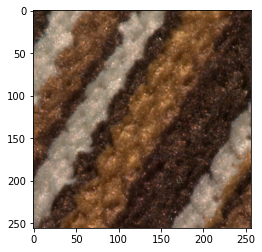

In [83]:
MATERIAL = 37
FRAME = 40
input_batch = import_picture(material=MATERIAL, frame=FRAME)
stats = import_stats(material=MATERIAL, frame=FRAME)
output = get_all_predictions(input_batch, stats)
output

Directionality  Pattern strength  Pattern number  \
Original                       0.574100          4.802000        1.000000   
AlexNet                        0.472792          2.384273        1.403742   
GoogleNet                      0.616636          8.602780        1.328394   
Multiloss model                0.498269          4.167932        1.379409   
Special statistic model             NaN          3.664299             NaN   

                         Colors number  
Original                      1.000000  
AlexNet                       1.116151  
GoogleNet                     1.024506  
Multiloss model               1.130811  
Special statistic model            NaN

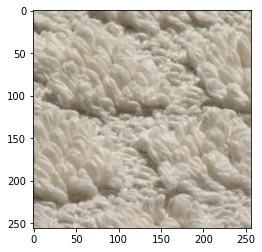

In [84]:
MATERIAL = 100
FRAME = 40
input_batch = import_picture(material=MATERIAL, frame=FRAME)
stats = import_stats(material=MATERIAL, frame=FRAME)
output = get_all_predictions(input_batch, stats)
output

Directionality  Pattern strength  Pattern number  \
Original                       0.779000         13.262400        1.000000   
AlexNet                        0.709109         16.597338        1.186229   
GoogleNet                      0.625198          8.692789        1.343509   
Multiloss model                0.807163         16.894766        1.163809   
Special statistic model             NaN         16.981564             NaN   

                         Colors number  
Original                      1.000000  
AlexNet                       1.207490  
GoogleNet                     1.039924  
Multiloss model               0.615007  
Special statistic model            NaN

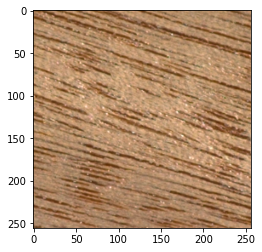

In [85]:
MATERIAL = 202
FRAME = 40
input_batch = import_picture(material=MATERIAL, frame=FRAME)
stats = import_stats(material=MATERIAL, frame=FRAME)
output = get_all_predictions(input_batch, stats)
output

Directionality  Pattern strength  Pattern number  \
Original                       0.125600          1.161100        2.000000   
AlexNet                        0.472792          2.384273        1.403742   
GoogleNet                      0.599649          8.381075        1.293559   
Multiloss model                0.498269          4.167932        1.379409   
Special statistic model             NaN          1.891466             NaN   

                         Colors number  
Original                      1.000000  
AlexNet                       1.116151  
GoogleNet                     0.996360  
Multiloss model               1.130811  
Special statistic model            NaN

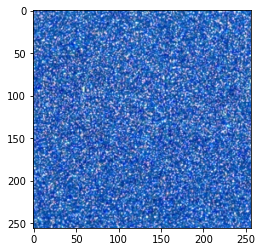

In [86]:
MATERIAL = 16
FRAME = 50
input_batch = import_picture(material=MATERIAL, frame=FRAME)
stats = import_stats(material=MATERIAL, frame=FRAME)
output = get_all_predictions(input_batch, stats)
output